In [3]:
%matplotlib inline

import pickle

import dgl
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml

from src.model.get_model import get_model
from src.utils.preprocess_data import preprocess_data

matplotlib.rcParams['font.family'] = ['Noto Serif', 'Serif']
plt.style.use('seaborn-poster')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Figure 1. Prediction Performance

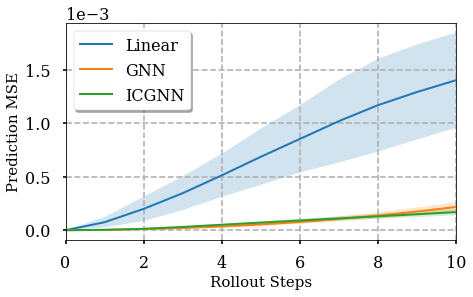

In [4]:
model_names = ['Linear', 'GNN', 'ICGNN']

# Load Data
data_generation_config = yaml.safe_load(open('config/data/data_generation_config.yaml', 'r'))
data_preprocessing_config = yaml.safe_load(open('config/data/data_preprocessing_config.yaml', 'r'))
test_data = pickle.load(open(data_generation_config['test_data_saved_path'], 'rb'))
test_config = yaml.safe_load(open('config/prediction/test_config.yaml', 'r'))

# Do Prediction Task
history_len = test_config['history_len']
receding_horizon = test_config['receding_horizon']

data_preprocessing_config['history_len'] = history_len
data_preprocessing_config['receding_horizon'] = receding_horizon
data_preprocessing_config['device'] = device
test_hist_xs, test_hist_us, test_future_us, test_future_xs, test_gs, test_idxs = preprocess_data(test_data,
                                                                                                 data_preprocessing_config)
with torch.no_grad():
    tg = dgl.batch([test_gs[idx[0]] for idx in test_idxs])
    thx = torch.cat([test_hist_xs[idx[0]][idx[1]] for idx in test_idxs])
    thu = torch.cat([test_hist_us[idx[0]][idx[1]] for idx in test_idxs])
    tfu = torch.cat([test_future_us[idx[0]][idx[1]] for idx in test_idxs])
    tfx = torch.cat([test_future_xs[idx[0]][idx[1]] for idx in test_idxs])

model_loss_dict = {}

def crit(x, y):
    loss_fn = torch.nn.SmoothL1Loss(reduction='none')
    mean = loss_fn(x, y).mean(dim=(0, 2)).detach().cpu().numpy()
    std = loss_fn(x, y).std(dim=(0, 2)).detach().cpu().numpy()
    mean = np.concatenate([[0], mean])
    std = np.concatenate([[0], std])
    return mean, std

for model_name in model_names:
    model_config = yaml.safe_load(open('config/model/{}/model_config.yaml'.format(model_name), 'r'))
    m = get_model(model_name, model_config, True).to(device)
    with torch.no_grad():
        pfx = m.multistep_prediction(tg, thx, thu, tfu)
        model_loss_dict[model_name] = crit(tfx, pfx)

# Visualize Prediction Performance

gamma = 0.1
label_size = 15
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
for model_name in model_loss_dict.keys():
    mean = model_loss_dict[model_name][0]
    std = model_loss_dict[model_name][1]
    axes.plot(mean, label=model_name, linewidth=2)
    axes.fill_between(range(mean.shape[0]),
                      mean - gamma * std,
                      mean + gamma * std, alpha=0.2)
axes.set_xlabel(r'Rollout Steps', fontsize=label_size)
axes.set_ylabel(r'Prediction MSE', fontsize=label_size)
axes.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axes.legend(fancybox=True, shadow=True)
axes.grid(True, which='both', ls='--')
axes.set_xlim(0, 10)
fig.savefig('prediction.pdf', bbox_inches='tight')
plt.show()

# Figure 2. Heater Location Optimization Performance Loss vs # of Optimization Steps

In [5]:
import pickle

import numpy as np

UnicodeDecodeError: 'cp949' codec can't decode byte 0x80 in position 0: illegal multibyte sequence

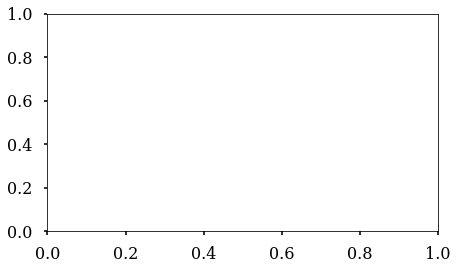

In [11]:
target = pickle.load(open('data/bilevel_design_opt/target.pkl', 'rb'))

def measure_design_opt_control(mpc_config, x_trajectory_list, u_trajectory_list):
    ridge_coefficient = mpc_config['ridge_coefficient']
    smoothness_coefficient = mpc_config['smoothness_coefficient']
    target_values_list = mpc_config['target_values_list']
    target_times_list = mpc_config['target_times_list']

    num_sensors = x_trajectory_list[0].shape[1]
    num_heaters = u_trajectory_list[0].shape[1]
    target_list = []
    for (target_values, target_times) in zip(target_values_list, target_times_list):
        target = np.array(generate_target_trajectory(target_values, target_times))
        target = np.reshape(target, newshape=(-1, 1))
        target = np.concatenate([target for _ in range(num_sensors)], axis=1)
        target_list.append(target)
    loss_list = []

    def compute_mpc_loss(x_traj, u_traj, target):
        loss_obj = np.square(x_traj[1:] - target).mean(axis=0).sum()
        loss_ridge = ridge_coefficient * np.square(u_traj).mean(axis=0).sum()
        u_prev = np.concatenate([np.zeros((1, num_heaters)), u_traj[:-1]], axis=0)
        loss_smoothness = smoothness_coefficient * np.square(u_traj - u_prev).mean(axis=0).sum()
        return loss_obj + loss_ridge + loss_smoothness

    for (x_traj, u_traj, target) in zip(x_trajectory_list, u_trajectory_list, target_list):
        loss_list.append(compute_mpc_loss(x_traj, u_traj, target))
    return np.array(loss_list)

num_x = 4
num_heaters = 5
model_names = ['GAT']

mpc_config = {
    'ridge_coefficient': 0.0,
    'smoothness_coefficient': 0.0,
    'target_values_list': target['target_values'],
    'target_times_list': target['target_times'],
    'max_iter': 200,
    'loss_threshold': 1e-9,
    'opt_config': {'lr': 2e-0},
    'scheduler_config': {'patience': 5, 'factor': 0.5, 'min_lr': 1e-4}
}

fig, axes = plt.subplots(1, 1, figsize=(6, 4))

for model_name in model_names:
    true_loss_dict = pickle.load(open('bilevel_opt_result/optimal/true_loss/implicit_{}/{}_{}.pkl'.format(model_name, num_x, num_heaters)))
    x_trajectory_list = true_loss_dict['x_trajectory_list']
    u_trajectory_list = true_loss_dict['u_trajectory_list']
    log_trajectory_list = true_loss_dict['log_trajectory_list']
    print('Model: {}, Length: {}'.format(model_name, len(x_trajectory_list)))
    loss_curve = []
    for itr in range(len(x_trajectory_list)):
        loss_list = measure_design_opt_contrl(mpc_config, x_trajectory_list[itr], u_trajectory_list[itr])
        loss_curve.append(np.mean(loss_list))
    axes.plot(loss_curve, label=model_name)
fig.show()

In [11]:
num_x = 4
num_heaters = 5
r = 8
model_name = 'ICGAT'
itr = 0
with open('bilevel_opt_result/implicit_{}/{}_{}.pkl'.format(model_name, num_x, num_heaters), 'rb') as f:
    optimal_experiment_result = pickle.load(f)

In [14]:
optimal_experiment_result['design_opt_log'].keys()

dict_keys(['total_loss_trajectory', 'position_trajectory', 'us_trajectory', 'lower_level_log_trajectory', 'best_idx', 'best_loss', 'best_position', 'best_us'])

In [13]:
np.argmin(optimal_experiment_result['design_opt_log']['total_loss_trajectory'], axis=1).shape

(101,)

In [16]:
optimal_experiment_result['design_opt_log']['position_trajectory'].shape

(101, 10, 5, 2)

In [10]:
def measure_design_opt_control(mpc_config, experiment_result):
    ridge_coefficient = mpc_config['ridge_coefficient']
    smoothness_coefficient = mpc_config['smoothness_coefficient']
    target_values_list = mpc_config['target_values_list']
    target_times_list = mpc_config['target_times_list']

    x_trajectory_list = experiment_result['x_trajectory_list']
    u_trajectory_list = experiment_result['u_trajectory_list']
    log_trajectory_list = experiment_result['log_trajectory_list']
    num_sensors = x_trajectory_list[0].shape[1]
    num_heaters = u_trajectory_list[0].shape[1]
    target_list = []
    for (target_values, target_times) in zip(target_values_list, target_times_list):
        target = np.array(generate_target_trajectory(target_values, target_times))
        target = np.reshape(target, newshape=(-1, 1))
        target = np.concatenate([target for _ in range(num_sensors)], axis=1)
        target_list.append(target)
    loss_list = []

    def compute_mpc_loss(x_traj, u_traj, target):
        loss_obj = np.square(x_traj[1:] - target).mean(axis=0).sum()
        loss_ridge = ridge_coefficient * np.square(u_traj).mean(axis=0).sum()
        u_prev = np.concatenate([np.zeros((1, num_heaters)), u_traj[:-1]], axis=0)
        loss_smoothness = smoothness_coefficient * np.square(u_traj - u_prev).mean(axis=0).sum()
        return loss_obj + loss_ridge + loss_smoothness

    for (x_traj, u_traj, target) in zip(x_trajectory_list, u_trajectory_list, target_list):
        loss_list.append(compute_mpc_loss(x_traj, u_traj, target))
    return np.array(loss_list)

num_x = 4
num_heaters = 5
r = 8
model_names = ['Linear', 'GNN', 'ICGNN']

true_loss_curve_dict = {}
for model_name in model_names:
    true_loss_curve_dict[model_name] = []
    with open('design_opt_experiment/{}_{}/design_opt_experiment_result_{}_1.0_{}.pkl'.format(num_x,
                                                                                             num_heaters,
                                                                                             model_name,
                                                                                             r),
              'rb') as f:
        design_opt_experiment_result = pickle.load(f)
    for itr in range(101):
        with open('design_opt_experiment/optimal/{}_{}/mpc_config_{}_1.0_{}.pkl'.format(num_x,
                                                                                       num_heaters,
                                                                                       model_name,
                                                                                       r),
                  'rb') as f:
            mpc_config = pickle.load(f)        
        with open('design_opt_experiment/optimal/{}_{}/log_compute/optimal_experiment_result_{}_1.0_{}_{}.pkl'.format(num_x,
                                                                                                                     num_heaters,
                                                                                                                     model_name,
                                                                                                                     r,
                                                                                                                     itr),
                  'rb') as f:
            optimal_experiment_result = pickle.load(f)
        opt_loss = measure_design_opt_control(mpc_config, optimal_experiment_result)
        true_loss_curve_dict[model_name].append(np.mean(opt_loss))


fig, axes = plt.subplots(1, 1, figsize=(7, 4))
color_dict = {'Linear': 'blue',
              'GAT': 'orange',
              'ICGAT': 'green'}
model_name = 'ICGAT'
axes.plot(true_loss_curve_dict[model_name], color=color_dict[model_name], linewidth=4, label='{}NN, Implicit (Ours)'.format(model_name[:-2]))
with open('design_opt_experiment/{}_{}/design_opt_experiment_result_{}_{}_{}.pkl'.format(num_x,
                                                                                         num_heaters,
                                                                                         model_name,
                                                                                         data_ratio,
                                                                                         r),
          'rb') as f:
    design_opt_experiment_result = pickle.load(f)
log = design_opt_experiment_result['design_opt_log']
approx_loss = log['total_loss_trajectory']
# axes.plot(approx_loss/32, color=color_dict[model_name], linewidth=4, label='{}NN, Approx. Loss'.format(model_name[:-2]))
# for idx in idx_list:
    # axes.scatter(idx, true_loss_curve_dict[model_name][idx], color=color_dict2[model_name], s=100, zorder=2)
# axes.scatter(log['best_idx'], true_loss_curve_dict[model_name][log['best_idx']], label='{}NN, Final Layout'.format(model_name[:-2]), color=color_dict2[model_name], marker='*', s=400, zorder=2)
axes.set_ylim([0.0, 0.12])
axes.legend(fontsize=25)
axes.xaxis.set_tick_params(labelsize=15)
axes.yaxis.set_tick_params(labelsize=15)
axes.set_xlabel('# of Iteration', fontsize=25)
axes.set_ylabel('Control Loss', fontsize=25)
fig.tight_layout()
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: 'design_opt_experiment/4_5/design_opt_experiment_result_Linear_1.0_7.pkl'

# Figure 3. Heater Location Optimization Performance: Loss vs # of heaters